In [1]:
!nvidia-smi

Mon Dec 22 12:39:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import sys
import os

!git clone https://github.com/mv-lab/InstructIR.git
sys.path.append("InstructIR/")

Cloning into 'InstructIR'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 164 (delta 10), reused 10 (delta 10), pack-reused 149 (from 1)
Receiving objects: 100% (164/164), 87.86 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
os.chdir("InstructIR/")
!ls

app.py	     demo.ipynb		 metrics.py		  results    utils.py
cog.yaml     eval_instructir.py  models			  static
configs      images		 predict.py		  test-data
data	     index.html		 README.md		  test.py
datasets.py  LICENSE		 requirements_gradio.txt  text


In [4]:
!pip install torch

In [5]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random

import torch
import torch.nn as nn

from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)



In [6]:
CONFIG     = "configs/eval5d.yml"
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

In [7]:
!ls models/

im_instructir-7d.pt  lm_instructir-7d.pt  nafnet_utils.py
instructir.py	     nafnet.py		  __pycache__


In [8]:
print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
cuda
IMAGE MODEL CKPT: models/im_instructir-7d.pt
Loaded weights! 15.843363


In [9]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head #.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


Running InstructIR!

In [10]:
def _linear_input_device_fix(mod, inputs):
    # inputs: (mat1, ...) for F.linear -> 確保 mat1 與 weight 在同一裝置
    if not inputs:
        return inputs
    x = inputs[0]
    if torch.is_tensor(x) and x.device != mod.weight.device:
        x = x.to(mod.weight.device, non_blocking=True)
        # 回傳新的參數 tuple
        return (x,) + inputs[1:]
    return inputs

_linear_hooks = [
    m.register_forward_pre_hook(_linear_input_device_fix)
    for m in model.modules() if isinstance(m, nn.Linear)
]

In [11]:
def process_img (image, prompt):
    """
    Given an image and a prompt, we run InstructIR to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0).to(device)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd #.to(device) # Assuming lm_head is already on the correct device
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img

In [ ]:
import os
import glob
import random


def get_random_image_path(img_root="/content/InstructIR/images"):
    # 支援多種常見圖片格式
    patterns = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    files = []
    for p in patterns:
        files.extend(glob.glob(os.path.join(img_root, p)))

    if not files:
        raise FileNotFoundError(f"No images found in {img_root}")

    return random.choice(files)

# 1. 隨機挑一張圖片
IMG = get_random_image_path("/content/InstructIR/images")
image  = load_img(IMG)
print("Using image:", IMG)

# 2. 文字指令可以自訂
PROMPT1 = "Remove blur and haze, enhance sharpness, and restore natural details."
#讓圖片變清晰（去模糊/去霧/提升細節）
PROMPT2 = "Adjust color tone, increase brightness slightly, and keep colors natural."
#更改圖片色調(色彩飽和)

# 3. 下面維持原本流程
restored_image = process_img(image, PROMPT1)
restored_image = process_img(image, PROMPT2)

# 如果要存檔就把註解打開
# save_rgb(restored_image, "result.png")

#plot_all([image, restored_image], names=["Before", "After"], figsize=(10, 5))
result1 = process_img(image, PROMPT1)
result2 = process_img(image, PROMPT2)


plot_all([image, result1, result2], figsize=(14,7))

Using image: /content/InstructIR/images/gopro.png


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 4097 has 14.73 GiB memory in use. Of the allocated memory 13.89 GiB is allocated by PyTorch, and 731.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Control the process

Sometimes the blur, rain, or film grain noise are pleasant effects and part of the **"aesthetics"**.

Here we show a simple example on how to interact with InstructIR
> Disclaimer: please remember this is not a product, thus, you will notice some limitations.

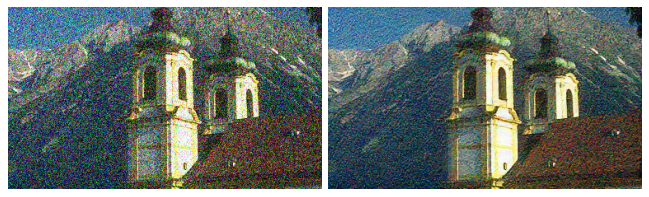

In [ ]:
IMG    = "images/rain-020.png"


PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

The final result looks indeed stunning :)

Using image: /content/InstructIR/images/lol_748.png


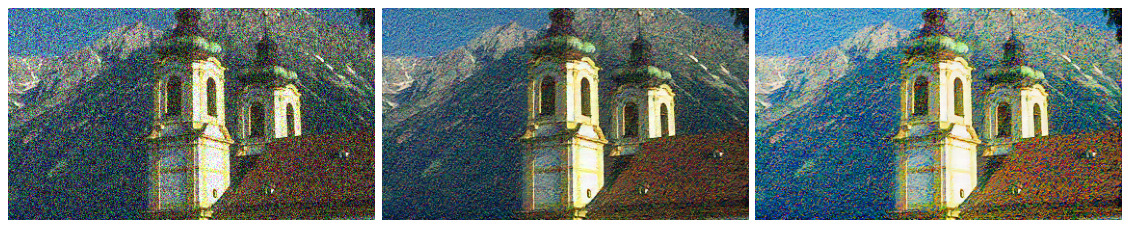

In [ ]:
# 1. 隨機挑一張圖片
IMG = get_random_image_path("/content/InstructIR/images")
print("Using image:", IMG)

PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )

PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )

#plot_all([image, result1], figsize=(8,4))
plot_all([image, result1, result2], figsize=(14,7))


In [ ]:
# PROMPT2 = "Can you make it look stunning? like a professional photo"
# result2 = process_img(result1, PROMPT2 )
# plot_all([result1, result2], figsize=(8,4))